# MNE : From raw data to epochs and evoked responses (ERF/ERP)

`
Authors:
Alexandre Gramfort
Denis A. Engemann
Jona Sassenhagen
`

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

First, load the mne package:

In [2]:
import mne

We set the log-level to 'warning' so the output is less verbose

In [3]:
mne.set_log_level('warning')

### Remember if you need help just ask... the machine

In [4]:
mne.pick_types?

## Access raw data

Now we import the sample dataset.

You should already have it but if you don't it will be downloaded automatically (but be patient approx. 2GB)

In [5]:
from mne.datasets import sample
# also explore other datasets, e.g. mne.datasets.XXX
data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

In [6]:
print(raw_fname)

/Users/alex/work/src/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


Read data from file:

In [7]:
raw = mne.io.read_raw_fif(raw_fname, preload=False)
print(raw)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec)>


Note the `preload=False` which states that no data is actually in memory.

For more details about IO of different file formats see [IO with MNE](http://martinos.org/mne/dev/manual/io.html)

Now let's look at the metadata about this file. It will give details about:

   - sampling rate
   - filtering parameters
   - available channel types
   - bad channels
   - etc.

In [8]:
print(raw.info)

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : 'mne.io.meas_info._ChannelNameList | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : unicode | /Users/ale.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 0.10000000149 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : numpy.ndarray | 2002-12-03 20:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : Non

In [9]:
raw.info['sfreq']

150.15374755859375

In [10]:
raw.info['bads']  # list of marked bad channels

[u'MEG 2443', u'EEG 053']

Next let's see what channels are present. It is available via the `raw.ch_names` attribute.

In [11]:
raw.ch_names

<ChannelNameList | 376 channels | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123 ... EEG 057, EEG 058, EEG 059, EEG 060, EOG 061>

You can index it as a list

In [12]:
raw.ch_names[42]

u'MEG 0432'

In [13]:
raw.ch_names[:10]

[u'MEG 0113',
 u'MEG 0112',
 u'MEG 0111',
 u'MEG 0122',
 u'MEG 0123',
 u'MEG 0121',
 u'MEG 0132',
 u'MEG 0133',
 u'MEG 0131',
 u'MEG 0143']

To access the data just use the [] syntax as to access any element of a list, dict etc.

In [14]:
data, times = raw[:, :10]  # fetch all channels and the first 10 time points
print(data.shape)
print(times.shape)

(376, 10)
(10,)


Note that it returns both the data and the times array.

# Plotting the hard way

Read and plot a segment of raw data

In [15]:
start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
data, times = raw[:306, start:stop]
print(data.shape, times.shape, times.min(), times.max())

((306, 2252), (2252,), 99.997504185773124, 114.98880501309083)


Take some magnetometer data and plot it

In [16]:
mne.pick_types?

In [17]:
picks = mne.pick_types(raw.info, meg='mag', exclude=[])
print(picks)

[  2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158 161
 164 167 170 173 176 179 182 185 188 191 194 197 200 203 206 209 212 215
 218 221 224 227 230 233 236 239 242 245 248 251 254 257 260 263 266 269
 272 275 278 281 284 287 290 293 296 299 302 305]


In [18]:
import matplotlib.pyplot as plt

In [19]:
#%matplotlib inline
plt.plot(times, data[picks].T)  # T for transpose
plt.xlim(times[0], times[-1])
plt.xlabel('time (s)')
plt.ylabel('MEG data (T)');  # the ; is an IPython directive, not needed as in MATLAB


# ... or use MNE plotters

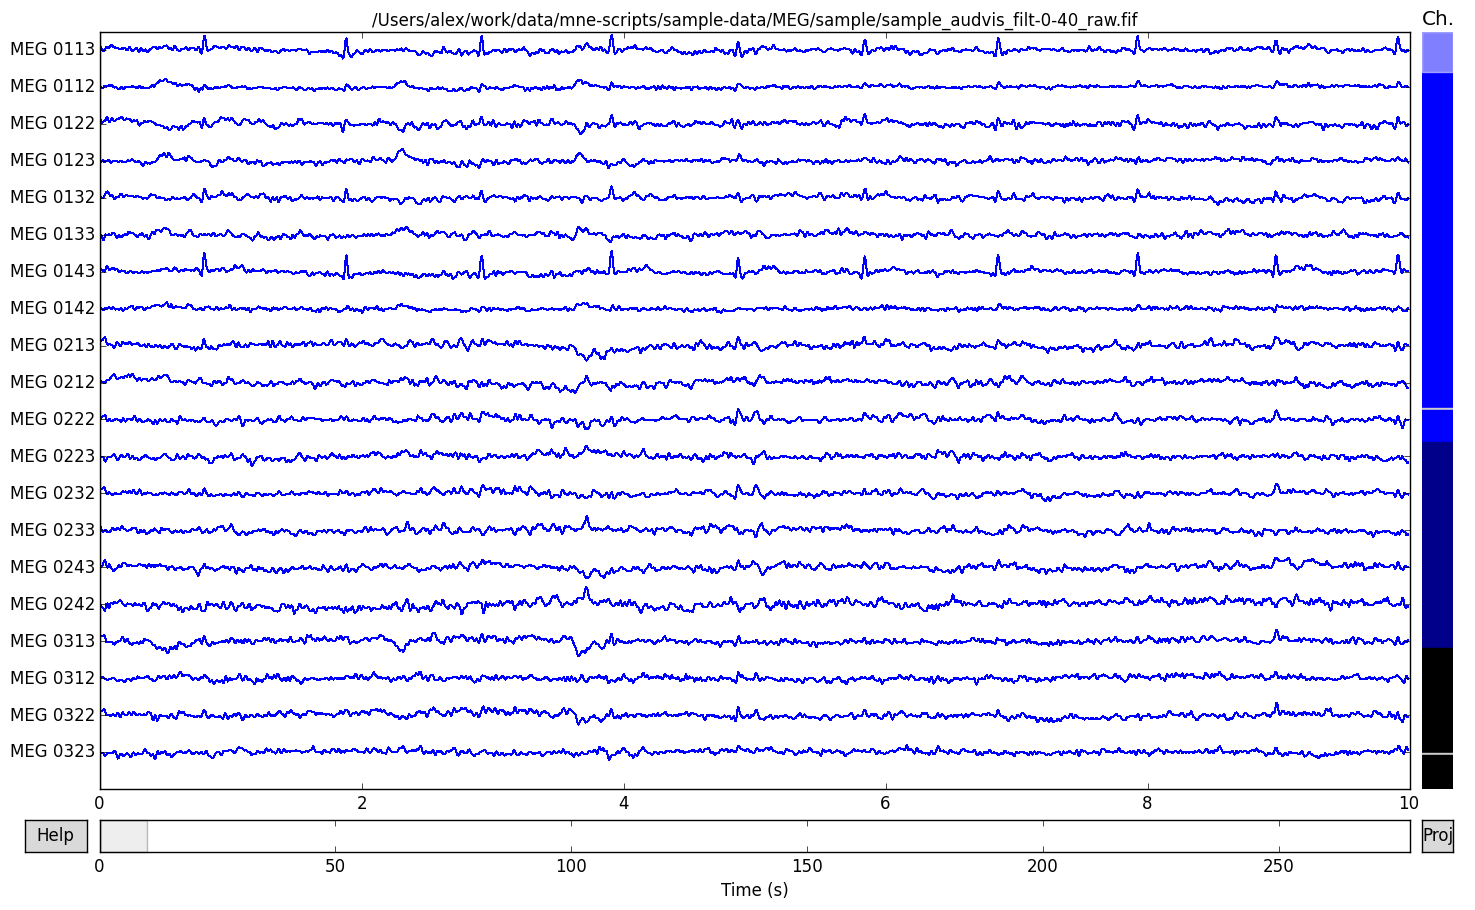

In [20]:
%matplotlib qt

raw.plot()

Save a segment of 150s of raw data (MEG only):

In [20]:
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
raw.save('sample_audvis_meg_raw.fif', tmin=0., tmax=150., picks=picks_meg, overwrite=True)

### Filtering

In [21]:
raw_beta = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering

# keep beta band
raw_orig = raw_beta.copy()
raw_beta.filter(13.0, 30.0, method='iir')

# save the result
raw_beta.save('sample_audvis_beta_raw.fif', overwrite=True)

print(raw_beta.info)  # note the update of raw.info['lowpass'] and raw.info['highpass']

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : 'mne.io.meas_info._ChannelNameList | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : unicode | /Users/ale.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 13.0 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 30.0 Hz
    meas_date : numpy.ndarray | 2002-12-03 20:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
   

## Exercise :

- Filter the raw data between 1Hz and 40Hz. Observe the absence of the slow drifts.
- Plot the magnetometers and the gradiometers separately. Observe the different units.

## Define and read epochs

First extract events:

In [22]:
events = mne.find_events(raw, stim_channel='STI 014')

In [23]:
# See parameters to fine tune event detection, e.g. consecutive non-zero
# mne.find_events?

In [24]:
print(events[:5])  # events is a 2d array, (time, previous, trigger)

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [25]:
len(events[events[:, 2] == 2])

73

In [26]:
len(events)

319

Where are they coming from?

In [27]:
d, t = raw[raw.ch_names.index('STI 014'), :]
d.shape

(1, 41700)

In [28]:
raw.ch_names.index('STI 014')

312

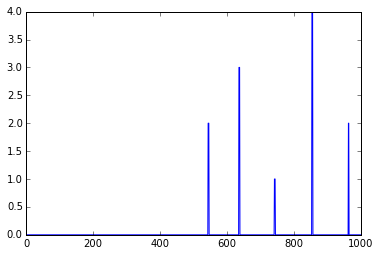

In [29]:
%matplotlib inline
plt.plot(d[0,:1000]);

Events are stored as 2D numpy array where the first column is the time instant and the last one is the event number. It is therefore easy to manipulate.

In [30]:
events_new = events.copy()
events_new[events_new[:, 2] == 2, 2] = 1  # MATLAB- and R-like syntax
events_new[events_new[:, 2] == 4, 2] = 3
print(events_new[:5])
print(events[:5])

[[6994    0    1]
 [7086    0    3]
 [7192    0    1]
 [7304    0    3]
 [7413    0    1]]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


For event trigger and conditions we use a Python dictionary with keys that contain "/" for grouping sub-conditions

In [31]:
event_id = {"visual/left": 3, "visual/right": 4, "auditory/left": 1, "auditory/right": 2}

event 5 missing from event_id will be ignored
event 32 missing from event_id will be ignored


-c:1: RuntimeWarning: event 5 missing from event_id will be ignored
-c:1: RuntimeWarning: event 32 missing from event_id will be ignored


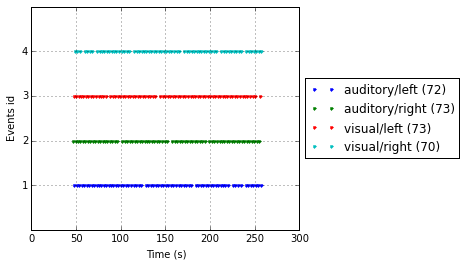

In [32]:
fig = mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id);

Define epochs parameters:

In [33]:
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

Define the baseline period:

In [34]:
baseline = (None, 0)  # means from the first instant to t = 0

Define peak-to-peak (amplitude range) rejection parameters for gradiometers, magnetometers and EOG:

In [35]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)  # this can be highly data dependent

In [36]:
# we are picky again, this time with EOG
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=True,
                           stim=False, exclude='bads')
# we start by looking at magnetometer and gradiometer signals

Extract epochs:

In [37]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks_meg, baseline=baseline, reject=reject)

In [38]:
print(epochs)

<Epochs  |  n_events : 288 (good & bad), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'auditory/left': 72, 'auditory/right': 73, 'visual/left': 73, 'visual/right': 70>


Explore the epochs namespace

Hit ``epochs.<TAB>``

### The epochs object is your MNE swiss army knife for processing segmented data!

- specialized methods for diagnostic plotting of data
- averaging
- saving
- manipulating data, e.g., rearranging or deleting single trials, resampling

more MNE plotters ...

In [26]:
%matplotlib qt

epochs.plot()  # Google Summer of code 2015 with Jaakko Leppäkangas

## More diagnostic plotting

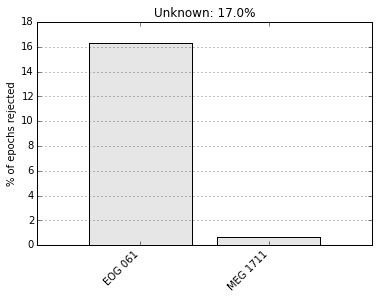

In [39]:
# %matplotlib inline
epochs.drop_bad_epochs()
epochs.plot_drop_log();

In [40]:
for drop_log in epochs.drop_log[:20]:
    print(drop_log)

[u'EOG 061']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['IGNORED']
[u'EOG 061']
['IGNORED']
[]
[]


In [41]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks_meg, baseline=baseline, reject=reject)
epochs.drop_bad_epochs()
print(epochs.events.shape)
print(epochs.selection)

(239, 3)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  38  39  40  42
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  63  64  66  67
  68  69  70  71  72  73  74  75  76  77  78  81  82  87  88  90  91  92
  93  94  95  96  97  98 101 102 104 105 106 107 109 110 111 112 113 114
 115 116 117 118 121 122 123 125 126 127 128 129 130 131 132 133 134 135
 136 138 139 140 141 142 145 146 148 151 152 153 154 155 156 157 158 159
 160 161 162 165 167 168 169 170 171 173 174 175 176 177 179 182 184 186
 187 189 190 192 193 194 196 198 199 200 202 205 207 211 213 214 215 216
 218 219 220 221 222 223 224 225 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 248 249 252 253 254 255 256 257 259 261 262
 263 264 265 268 269 270 271 272 273 274 275 277 281 282 285 286 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 312 315 316 317]


In [42]:
epochs

<Epochs  |  n_events : 239 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'auditory/left': 55, 'auditory/right': 61, 'visual/left': 67, 'visual/right': 56>

## basic IO 

The standard scenario is saving the epochs into .fif file together with all the header data.

In [43]:
epochs.save('sample-epo.fif')  # note that epochs are save in files ending with -epo.fif

Scipy also supports reading and writing of matlab files. You can save your single trials with:

In [44]:
from scipy import io
epochs_data = epochs.get_data()
print(epochs_data.shape)
io.savemat('epochs_data.mat', dict(epochs_data=epochs_data),
           oned_as='row')

(239, 306, 106)


### Average the epochs to get ERF/ERP and plot it!

In [45]:
evoked = epochs.average()
print(evoked)

<Evoked  |  comment : 'Unknown', kind : average, time : [-0.199795, 0.499488], n_epochs : 239, n_channels x n_times : 305 x 106>


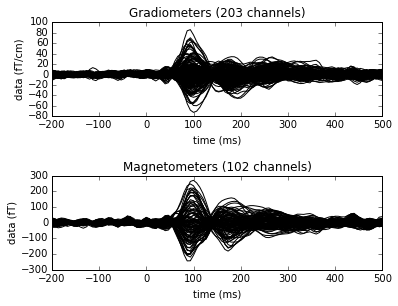

In [47]:
evoked.plot();

We can also show sensor position as line color:

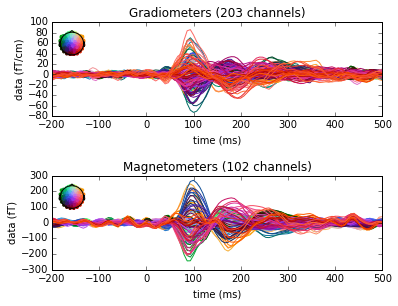

/Users/alex/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [48]:
evoked.plot(spatial_colors=True);  # note the legend

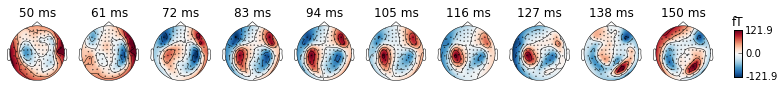

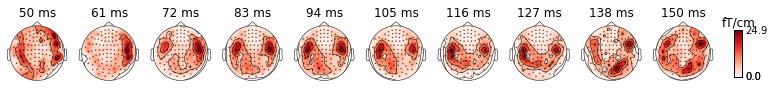

In [49]:
# pure topography plots called topomap in the MNE jargon
for ch_type in ('mag', 'grad'):
    evoked.plot_topomap(times=np.linspace(0.05, 0.15, 10), ch_type=ch_type);

Topoplot and time series can also be shown in one single plot:

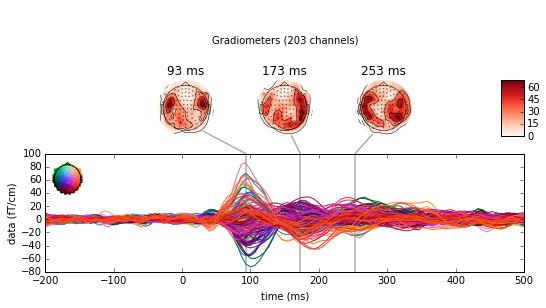

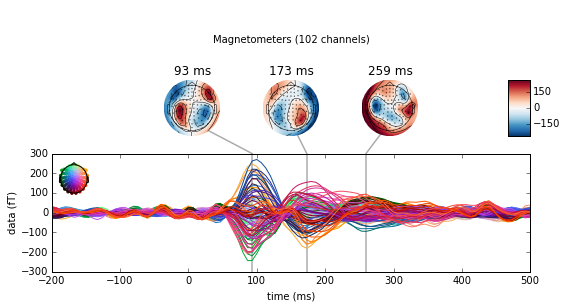

In [50]:
evoked.plot_joint();

## Accessing and indexing epochs by condition

Epochs can be indexed by integers or slices to select a subset of epochs but also with strings to select by conditions `epochs[condition]`

In [51]:
epochs[0]  # first epoch

<Epochs  |  n_events : 1 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0)>

In [52]:
epochs[:10]  # first 10 epochs

<Epochs  |  n_events : 10 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'auditory/left': 3, 'auditory/right': 2, 'visual/left': 3, 'visual/right': 2>

In [53]:
epochs['visual/left']  # epochs for the left visual condition

<Epochs  |  n_events : 67 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0)>

In [54]:
# remember ...
event_id

{'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3, 'visual/right': 4}

In event_id, "/" selects conditions in a hierarchical way, e.g. here, "auditory" vs. "visual", "left" vs. "right", and MNE can select them individually

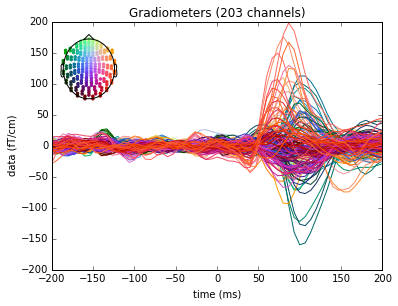

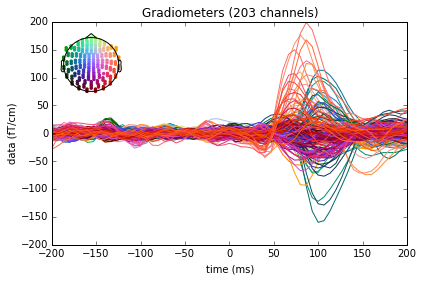

In [55]:
epochs['auditory/left'].average().pick_types(meg='grad').crop(None, 0.2).plot(spatial_colors=True)

In [56]:
epochs['visual']  # epochs for the visual condition (either left or right)

<Epochs  |  n_events : 123 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'visual/left': 67, 'visual/right': 56>

To access the data of some epochs use the get_data method.

In [57]:
epochs_data = epochs.get_data()
type(epochs_data), epochs_data.shape

(numpy.ndarray, (239, 306, 106))

`epochs_data` is a 3D array of dimension (239 epochs, 306 channels, 106 time instants).

Apply this to visualize all the conditions in `event_id`

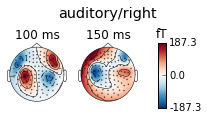

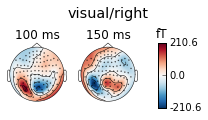

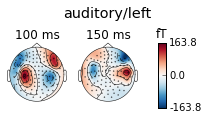

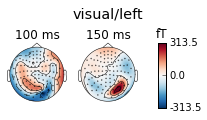

In [58]:
for condition in event_id:
    epochs[condition].average().plot_topomap(times=[0.1, 0.15], title=condition);

## Some Python + MNE Kung Fu to plot selected channels and conditions

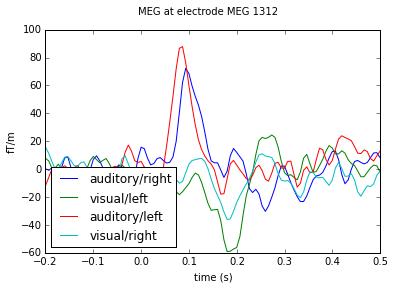

In [59]:
sensor = "MEG 1312"

evokeds = {k:epochs[k].average() for k in event_id}  # funny expression, no? Google "dict comprehension"

for condition, evoked in evokeds.items():  # that's what dictionaries are good for, looping!
    data = evoked.pick_channels([sensor], copy=True).data[0]
    plt.plot(evoked.times, data * 1e13, label=condition)

plt.legend(loc="lower left")
plt.ylabel("fT/m")
plt.xlabel("time (s)")
plt.suptitle("MEG at electrode {}".format(sensor));

## Customize your plots

What have every text in magenta?

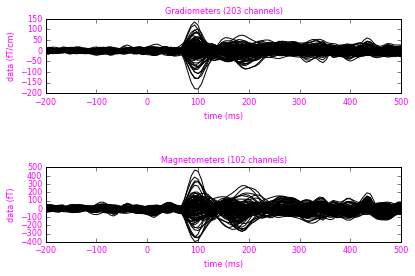

In [60]:
fig = evoked.plot(show=False)  # butterfly plots
fig.subplots_adjust(hspace=1.0)
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(8)
    text.set_color('magenta')
fig.savefig('plot_erf.pdf');

## Write evoked data to disk

In [61]:
evoked.save('sample-ave.fif')  # note that the file for evoked ends with -ave.fif

or to write multiple conditions in 1 file

In [62]:
evokeds_list = [epochs[k].average() for k in event_id]  # get evokeds
mne.write_evokeds('sample-ave.fif', evokeds_list)

### Reading evoked from disk

It is also possible to read evoked data stored in a fif file:

In [63]:
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked1 = mne.read_evokeds(evoked_fname, condition=0, baseline=(None, 0), proj=True)

Or another one stored in the same file:

In [64]:
evoked2 = mne.read_evokeds(evoked_fname, condition=1,
                           baseline=(None, 0), proj=True)

Or give the explicit name of the averaged condition:

In [65]:
evoked3 = mne.read_evokeds(evoked_fname, condition='Left Auditory',
                           baseline=(None, 0), proj=True)

Did you note that you can apply some preprocessing on reading the evokeds from disk?

### Compute a contrast:

In [66]:
contrast = evokeds["visual/left"] - evokeds["visual/right"]

Note that this combines evokeds in a **weighted way** so if you have imbalanced trial numbers, you might not get what you want

In [67]:
print(evokeds["visual/left"].nave)  # average of 67 epochs
print(contrast.nave)  # average of 123 epochs

67
123


In [68]:
print(contrast)

<Evoked  |  comment : 'visual/left - visual/right', kind : average, time : [-0.199795, 0.499488], n_epochs : 123, n_channels x n_times : 305 x 106>


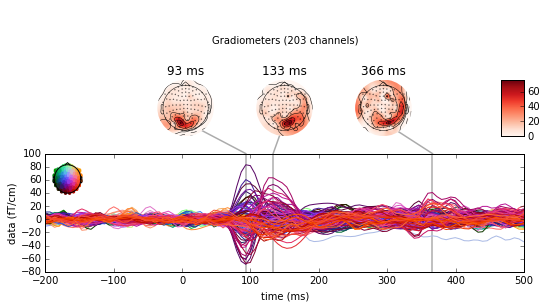

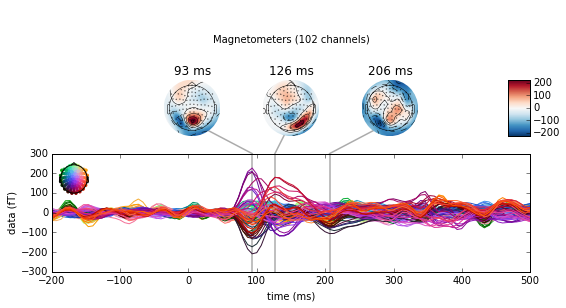

In [69]:
fig = contrast.plot_joint()

If you **DO NOT** want to do a weighted difference use `mne.combine_evoked`

### Save your figure as pdf

In [70]:
%matplotlib qt
import numpy as np
contrast.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag')
plt.savefig('toto.pdf')
!open toto.pdf

## Exercises

- Extract Epochs restricted to magnetometers on unfiltered data (sample_audvis_raw.fif)
- Construct epochs with a whole-epoch baseline. Then, filter raw data at 1 Hz, construct epochs from that. Compare the resulting Evokeds (filter vs. baseline)
- Plot the difference between all *visual* and all *auditory* stimulus presentations
- Recompute everything for EEG